In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201 
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, jaccard_score
import numpy as np
import os
from PIL import Image
from shutil import copyfile  # Import the copyfile function
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Dataset Describtion**

In [2]:
# Define the paths to our train, validation, and test datasets
train_data_dir =  '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/training'
test_data_dir = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing'
validation_data_dir = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing'

# Image dimensions
IMG_WIDTH, IMG_HEIGHT = 299, 299
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)  # RGB images


# **Data generators**

In [3]:
# Data generators for RGB images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)



# Define data generators for RGB images with augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)

# Generate augmented data for training
train_generator = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=10,
    class_mode='categorical',
  
)


# Define data generators for RGB images with augmentation
test_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=8,
    class_mode='categorical',
    shuffle=False,
   )

# Define data generators for RGB images with augmentation
validation_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Rotation angle range
    width_shift_range=0.2,  # Horizontal shift range
    height_shift_range=0.2,  # Vertical shift range
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=False,  # Do not flip images vertically
    fill_mode='nearest'  # Fill mode for newly created pixels
)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=8,
    class_mode='categorical',
    shuffle=True,
   
)




Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# **{'Fractured': 0, 'Non_fractured': 1}**

In [4]:
class_indices = train_generator.class_indices
print(class_indices)

{'fractured': 0, 'not_fractured': 1}


# **Number of images for each class in the training dataset**

In [5]:
# Count the number of images for each class in the training dataset
classes = os.listdir(train_data_dir)
for class_name in classes:
    class_path = os.path.join(train_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: not_fractured, Number of images: 4383
Class: fractured, Number of images: 4480


# **Check the shape of the images in Train Generator**

In [6]:
# Get a batch of images and labels from the train_generator
batch = train_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 299x299x3, Label: [0. 1.]
Image 2 - Shape: 299x299x3, Label: [0. 1.]
Image 3 - Shape: 299x299x3, Label: [1. 0.]
Image 4 - Shape: 299x299x3, Label: [0. 1.]
Image 5 - Shape: 299x299x3, Label: [0. 1.]
Image 6 - Shape: 299x299x3, Label: [1. 0.]
Image 7 - Shape: 299x299x3, Label: [0. 1.]
Image 8 - Shape: 299x299x3, Label: [1. 0.]
Image 9 - Shape: 299x299x3, Label: [1. 0.]
Image 10 - Shape: 299x299x3, Label: [1. 0.]


# **Number of images for each class in the testing dataset**

In [7]:
# Count the number of images for each class in the testing dataset
classes = os.listdir(test_data_dir)
for class_name in classes:
    class_path = os.path.join(test_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: not_fractured, Number of images: 240
Class: fractured, Number of images: 360


# **Check the shape of the images in Test Generator**

In [8]:
# Get a batch of images and labels from the test_generator
batch = test_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 299x299x3, Label: [1. 0.]
Image 2 - Shape: 299x299x3, Label: [1. 0.]
Image 3 - Shape: 299x299x3, Label: [1. 0.]
Image 4 - Shape: 299x299x3, Label: [1. 0.]
Image 5 - Shape: 299x299x3, Label: [1. 0.]
Image 6 - Shape: 299x299x3, Label: [1. 0.]
Image 7 - Shape: 299x299x3, Label: [1. 0.]
Image 8 - Shape: 299x299x3, Label: [1. 0.]


# **Number of images for each class in the validation dataset**

In [9]:
# Count the number of images for each class in the testing dataset
classes = os.listdir(validation_data_dir)
for class_name in classes:
    class_path = os.path.join(validation_data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of images: {num_images}")


Class: not_fractured, Number of images: 240
Class: fractured, Number of images: 360


# **Check the shape of the images in Validation Generator**

In [10]:
# Get a batch of images and labels from the validation_generator
batch = validation_generator.next()

# Iterate through the batch to check image shapes
for i in range(len(batch[0])):
    img = batch[0][i]  # Image data
    label = batch[1][i]  # Image label
    
    # Get image shape and channels
    height, width, channels = img.shape
    
    # Display image shape and channels
    print(f"Image {i+1} - Shape: {width}x{height}x{channels}, Label: {label}")


Image 1 - Shape: 299x299x3, Label: [1. 0.]
Image 2 - Shape: 299x299x3, Label: [1. 0.]
Image 3 - Shape: 299x299x3, Label: [1. 0.]
Image 4 - Shape: 299x299x3, Label: [0. 1.]
Image 5 - Shape: 299x299x3, Label: [1. 0.]
Image 6 - Shape: 299x299x3, Label: [1. 0.]
Image 7 - Shape: 299x299x3, Label: [1. 0.]
Image 8 - Shape: 299x299x3, Label: [1. 0.]


# **Check for GPU availability**

In [11]:
# Check for GPU availability
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

# Set TensorFlow to use the GPU device
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU device configured")
else:
    print("No GPU device found")

GPU is available
GPU device configured


# **Model checkpoint**

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_dir = '/kaggle/working/Checkpoints_densenet201'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

checkpoint_path = model_dir + '/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,  # Save only the best model
                                                 monitor="val_accuracy",   # Monitor validation loss
                                                 mode="max",           # Save the model when validation loss is minimized
                                                 verbose=1)

In [14]:
checkpoint_path

'/kaggle/working/Checkpoints_densenet201/cp.ckpt'

# **DenseNet for Feature Extractor** 
## **1.** DenseNet121
## **2.** DenseNet169
## **3.** DenseNet201

In [15]:
from tensorflow.keras import models, layers, optimizers

In [16]:
def create_model(summary=True):
    # apply transfer learning
    new_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=new_input) ##MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=new_input)
    # add new classifier layers
    flat1 = Flatten()(base_model.layers[-1].output)
    output = Dense(2, activation='softmax')(flat1)  
    # define new model
    model = Model(inputs=base_model.inputs, outputs=output)
    # Modify loss function to 'weighted_binary_crossentropy'
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    if summary:
        print(model.summary())
    return model


# **Model summary**

In [17]:
model = create_model()

74836368/74836368 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 305, 305, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 150, 150, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

# **Training starts here**

In [18]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[cp_callback]
    
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 3.2779 - accuracy: 0.5180
Epoch 1: saving model to /kaggle/working/Checkpoints_densenet201/cp.ckpt
100/100 [==============================] - 152s 339ms/step - loss: 3.2779 - accuracy: 0.5180 - val_loss: 64188452.0000 - val_accuracy: 0.3500
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 3.3045 - accuracy: 0.5180
Epoch 2: saving model to /kaggle/working/Checkpoints_densenet201/cp.ckpt
100/100 [==============================] - 28s 279ms/step - loss: 3.3045 - accuracy: 0.5180 - val_loss: 473.2800 - val_accuracy: 0.4250
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 2.1724 - accuracy: 0.5360
Epoch 3: saving model to /kaggle/working/Checkpoints_densenet201/cp.ckpt
100/100 [==============================] - 28s 282ms/step - loss: 2.1724 - accuracy: 0.5360 - val_loss: 93.2650 - val_accuracy: 0.5000
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 2.3759

# **Save model history in a CSV file**

In [20]:
# Save the training history
initial_epoch = 0  # or the actual initial epoch of the first training session
saved_history = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy'],
    # Add other metrics as needed
}


In [21]:
np.save("/kaggle/working/saved_D201history.npy", saved_history)

# **Again Train the loaded model**

In [22]:
# Load the latest checkpoint file
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
print(latest_checkpoint)

if latest_checkpoint is not None:
    # Create a new model instance
    loaded_model = create_model(summary=True)

    # Load the previously saved weights and silence the warnings
    status = loaded_model.load_weights(latest_checkpoint)
    status.expect_partial()  # Ignore unrestored variables
else:
    print("No checkpoint file found in the specified directory.")

/kaggle/working/Checkpoints_densenet201/cp.ckpt
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 305, 305, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 150, 150, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 150, 150

# Load the previous history

In [23]:
# Load the previous history
previous_history = np.load("/kaggle/working/saved_D201history.npy", allow_pickle=True).item()
initial_epoch = len(previous_history['loss'])
print(initial_epoch)


100


In [32]:
loaded_model.compile(optimizer=Adam(learning_rate=1e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
# Train the model
#initial_epoch = 20
new_history  = loaded_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=150,
    initial_epoch=initial_epoch,
    validation_data=validation_generator,
    validation_steps=30,
    callbacks=[cp_callback]
    
)

Epoch 101/150
100/100 [==============================] - ETA: 0s - loss: 0.4144 - accuracy: 0.8036
Epoch 101: val_accuracy improved from -inf to 0.60833, saving model to /kaggle/working/Checkpoints_densenet201/cp.ckpt
100/100 [==============================] - 137s 298ms/step - loss: 0.4144 - accuracy: 0.8036 - val_loss: 0.8291 - val_accuracy: 0.6083
Epoch 102/150
100/100 [==============================] - ETA: 0s - loss: 0.4103 - accuracy: 0.8060
Epoch 102: val_accuracy improved from 0.60833 to 0.64583, saving model to /kaggle/working/Checkpoints_densenet201/cp.ckpt
100/100 [==============================] - 26s 262ms/step - loss: 0.4103 - accuracy: 0.8060 - val_loss: 0.9296 - val_accuracy: 0.6458
Epoch 103/150
100/100 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.8190
Epoch 103: val_accuracy did not improve from 0.64583
100/100 [==============================] - 23s 233ms/step - loss: 0.3892 - accuracy: 0.8190 - val_loss: 0.8960 - val_accuracy: 0.6250
Epoch 

In [37]:
loaded_model.save_weights("/kaggle/working/dense201.weights.h5")

# **Again save the history after using latest weights in a CSV file**

In [38]:
# Update and save the training history
previous_history['loss'].extend(new_history.history['loss'])
previous_history['accuracy'].extend(new_history.history['accuracy'])
previous_history['val_loss'].extend(new_history.history['val_loss'])
previous_history['val_accuracy'].extend(new_history.history['val_accuracy'])
# Repeat for other metrics as needed

np.save("/kaggle/working/saved_D201history.npy", previous_history)

# **Accuracy and loss graph of training and validation**
## Here, No. of epochs and (xticks & yticks) will be changed

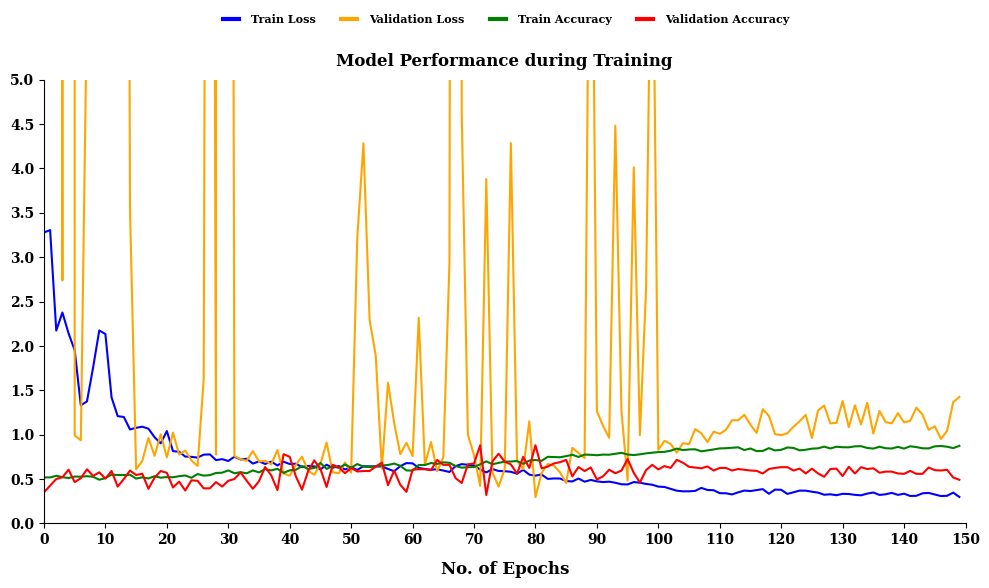

In [139]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
import numpy as np

# Plot training & validation loss values
plt.figure(figsize=(10, 6))

# Plot Loss
train_loss, = plt.plot(previous_history['loss'], label='Train Loss', color='blue')
val_loss, = plt.plot(previous_history['val_loss'], label='Validation Loss', color='orange')
train_accuracy, = plt.plot(previous_history['accuracy'], label='Train Accuracy',  color='green')
val_accuracy, = plt.plot(previous_history['val_accuracy'], label='Validation Accuracy', color='red')
# Add a title with specified font properties
plt.title('Model Performance during Training', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12},pad=10)
# Set x-axis label with specified font properties
plt.xlabel('No. of Epochs', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

# Set x-axis ticks font properties
#plt.xticks(np.linspace(0, len(history.history['loss']), num=6), fontname='Serif', weight='bold')

plt.xticks(np.linspace(0, 150, num=16), fontname='Serif', weight='bold')


# Set y-axis ticks font properties
plt.yticks(np.linspace(0, 5, num=11), fontname='Serif', weight='bold')

# Set the x-axis and y-axis limits
#plt.xlim(0, len(history.history['loss']))

plt.xlim(0, 150)
plt.ylim(0, 5)

# Define custom legend lines with desired line properties
legend_lines = [
    Line2D([0], [0], color='blue', lw=3),          # Train Loss
    Line2D([0], [0], color='orange', lw=3),       # Validation Loss
    Line2D([0], [0], color='green', lw=3),        # Train Accuracy
    Line2D([0], [0], color='red', lw=3)           # Validation Accuracy
]

# Place legend outside the graph by adjusting bbox_to_anchor and specifying it to be outside the axes
plt.legend(legend_lines, ['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'],
           loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=5,
           prop={'family': 'Serif', 'weight': 'bold', 'size': 8}, frameon=False,
           handler_map={Line2D: HandlerLine2D(numpoints=5)})

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('/kaggle/working/densenet201_accuracy_graph.pdf')  # Save as pdf format
plt.show()


# **Testing starts here**

## **Load the best checkpoint file**

In [70]:
# Load the latest checkpoint file
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
print(checkpoint_dir)
if latest_checkpoint is not None:
    # Create a new model instance
    loaded_model = create_model(summary=True)

    # Load the previously saved weights and silence the warnings
    status = loaded_model.load_weights(latest_checkpoint)
    status.expect_partial()  # Ignore unrestored variables
else:
    print("No checkpoint file found in the specified directory.")

/kaggle/working/Checkpoints_densenet201
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 zero_padding2d_8 (ZeroPadd  (None, 305, 305, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 150, 150, 64)         9408      ['zero_padding2d_8[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 150, 150, 64)   

In [41]:
loaded_model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

# **Evaluate the model on the test set**

In [71]:
test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

75/75 [==============================] - 10s 56ms/step - loss: 0.9322 - accuracy: 0.6467
Test Accuracy: 0.6466666460037231


In [72]:
# Predict labels for the test set
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Get the index of the highest probability class
true_classes = test_generator.classes

# Display some of the predicted and true classes
print("Predicted Classes:", predicted_classes[-10:])  # Display first 10 predicted classes
print("True Classes:", true_classes[-10:])  # Display first 10 true classes


75/75 [==============================] - 7s 49ms/step
Predicted Classes: [1 1 1 1 1 1 1 1 1 1]
True Classes: [1 1 1 1 1 1 1 1 1 1]


# **Evaluation Metircs**

In [73]:
print(f"Accuracy: {accuracy_score(true_classes, predicted_classes)}")
print(f"Precision: {precision_score(true_classes, predicted_classes)}")
print(f"Recall: {recall_score(true_classes, predicted_classes)}")
print(f"F1 Score: {f1_score(true_classes, predicted_classes)}")
print(f"Log Loss: {log_loss(true_classes, predicted_classes)}")
print(f"Jaccard Score: {jaccard_score(true_classes, predicted_classes)}")

Accuracy: 0.6466666666666666
Precision: 0.5391061452513967
Recall: 0.8041666666666667
F1 Score: 0.6454849498327759
Log Loss: 12.735424197488062
Jaccard Score: 0.4765432098765432


# **Classification Report**

In [74]:
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes,digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.8058    0.5417    0.6478       360
           1     0.5391    0.8042    0.6455       240

    accuracy                         0.6467       600
   macro avg     0.6724    0.6729    0.6467       600
weighted avg     0.6991    0.6467    0.6469       600



# **Confusion Matrix**

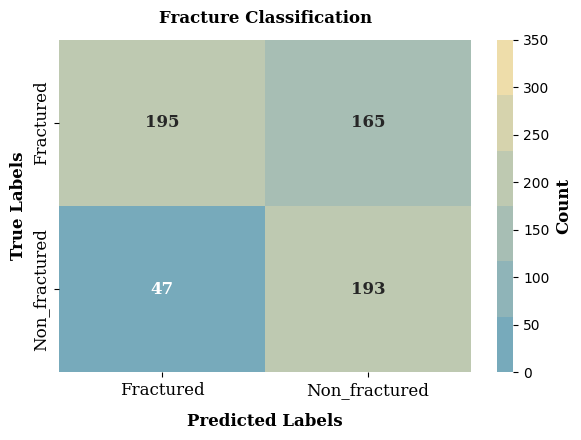

In [87]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4.5))
# Define the custom palette
custom_palette = sns.color_palette(palette='blend:#7AB,#EDA')# Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,vmin=0,vmax=350,
                      xticklabels=['Fractured', 'Non_fractured'], yticklabels=['Fractured', 'Non_fractured'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Fracture Classification', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
# Adjust layout to prevent cropping
plt.tight_layout()
plt.savefig('/kaggle/working/densenet201_cm.pdf')  # Save as pdf format
plt.show()


# **ROC curve for DenseNet201**

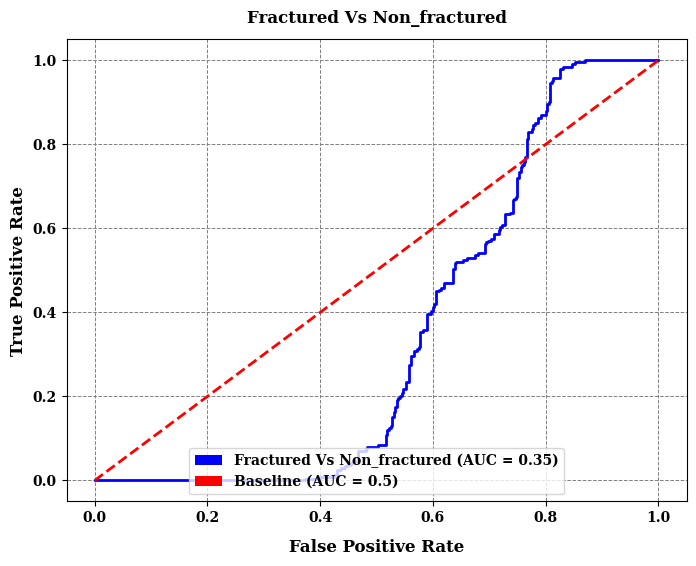

In [88]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# Assuming predicted probabilities for the "Fractured" class (class index 1)
positive_class_prob = predictions[:, 0]  # Adjust the index based on the column containing the probabilities
 # Replace 1 with the appropriate index for the "Fractured" class

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_classes, positive_class_prob)
roc_auc = roc_auc_score(true_classes, positive_class_prob)


# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate', fontdict=font)
plt.ylabel('True Positive Rate', fontdict=font)
plt.title('Fractured Vs Non_fractured', fontdict=font, pad=12)

# Create legend entries with bbox
legend_handles = [
    Patch(facecolor='blue',  label='Fractured Vs Non_fractured (AUC = %0.2f)' % roc_auc),
    Patch(facecolor='red',  label='Baseline (AUC = 0.5)')
]

# Combine loss and accuracy labels with custom legend lines and bbox
plt.legend(handles=legend_handles, loc='lower center', ncol=1, prop={'family': 'Serif', 'weight': 'bold', 'size': 10})

# Enable grid with customized properties
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')

# Set x-axis ticks font properties
plt.xticks(fontname='Serif', weight='bold')

# Set y-axis ticks font properties
plt.yticks(fontname='Serif', weight='bold')

# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space

plt.show()


# **Checking model predictions for random images from test dataset**

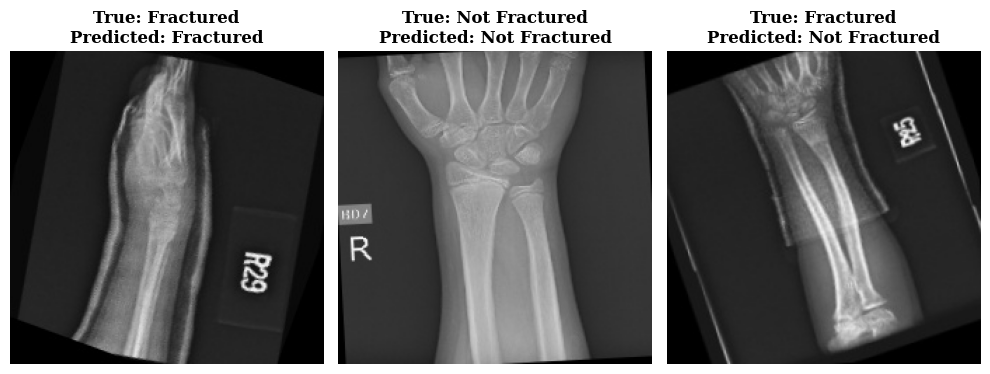

In [89]:
import random
import matplotlib.pyplot as plt
import cv2

# Get random indices for three images
random_indices = random.sample(range(len(true_classes)), 3)

plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices, 1):
    # Load the image
    img_path = test_generator.filepaths[idx]
    img = Image.open(img_path)
    
    # Display the image
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.axis('off')
    
    # Display the true and predicted labels
    true_label = "Fractured" if true_classes[idx] == 0 else "Not Fractured"
    predicted_label = "Fractured" if predicted_classes[idx] == 0 else "Not Fractured"
    
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}",fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})

plt.tight_layout()
plt.show()


# **Explainable AI (GradCAM)**

In [90]:
# Function to save and display GradCAM
def save_and_display_gradcam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/Dens201_gradcam.pdf')  
    plt.show()



In [91]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



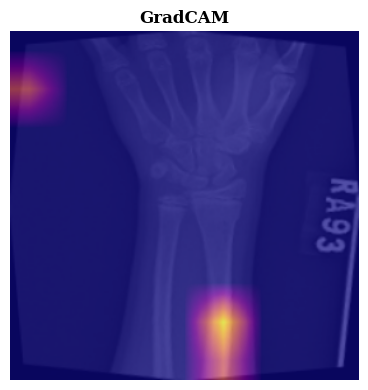

In [93]:
 # make a prediction and visualize grad-cam
def make_prediction_and_visualize_():
    img_path = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing/fractured/1-rotated1-rotated1-rotated2.jpg'

    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)


    last_conv_layer_name = 'conv5_block32_concat'

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_gradcam(img_path, heatmap)


make_prediction_and_visualize_()

# **Explainable AI (GradCAM++)**


In [94]:
# Function to save and display ScoreCAM
def save_and_display_gradcam_plusplus(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('GradCAM++', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/Dens201_gradcam_plusplus.pdf')  # Save as pdf format
    plt.show()



In [95]:
# Function to generate GradCAM++ heatmap
def make_gradcam_plusplus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get gradients
    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads[0], axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]

    # Calculate guided gradients
    guided_grads = tf.cast(last_conv_layer_output > 0, 'float32') * grads[0]

    # Calculate importance weights
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Generate heatmap
    heatmap = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)  # Normalize

    return heatmap.numpy()


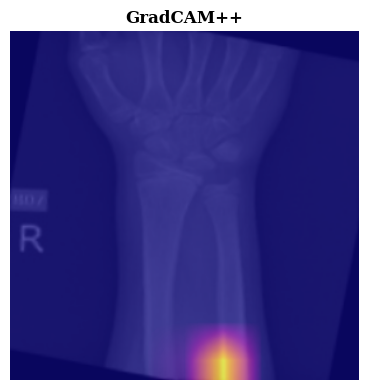

In [100]:
# Function to make a prediction and visualize GradCAM++
def make_prediction_and_visualize_gradcam_plusplus():
    img_path = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing/not_fractured/1-rotated2-rotated2-rotated1-rotated1.jpg'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size
    rescaled_img = img / 255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block32_concat'

    # Generate GradCAM++ heatmap
    heatmap = make_gradcam_plusplus_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_gradcam_plusplus(img_path, heatmap)

make_prediction_and_visualize_gradcam_plusplus()

# **Explainable AI (ScoreCAM)**


In [101]:
# Function to save and display ScoreCAM
def save_and_display_scorecam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the ScoreCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('ScoreCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/Dens201_scorecam.pdf')  # Save as pdf format
    plt.show()



In [102]:
import tensorflow as tf

def make_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get the gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)
    guided_grads = tf.cast(grads[0] > 0, 'float32') * grads[0]

    # GAP (Global Average Pooling) along the spatial dimensions
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Calculate the score-weighted activation map
    cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


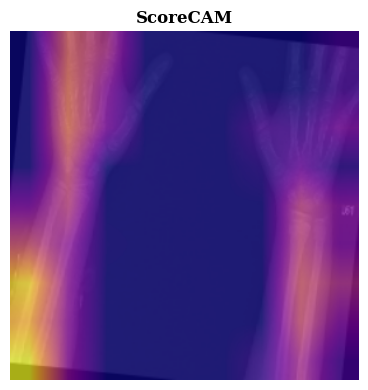

In [107]:
# make a prediction and visualize ScoreCAM
def make_prediction_and_visualize_scorecam():
    img_path = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/training/fractured/10-rotated1.jpg'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block32_concat'

    # Generate class activation heatmap
    heatmap = make_scorecam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_scorecam(img_path, heatmap)

make_prediction_and_visualize_scorecam()


# **Explainable AI (Faster Score-CAM)**


In [108]:
# Function to save and display Faster ScoreCAM
def save_and_display_faster_scorecam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the Faster ScoreCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Faster ScoreCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/Dens201_faster_scorecam.pdf')  # Save as pdf format
    plt.show()



# **Faster ScoreCAM function**

In [109]:
def faster_scorecam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_output = preds[:, pred_index]
        conv_output = last_conv_layer_output[0]

    # Get the gradient of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)[0]

    # Global average pooling (GAP) to compute weights
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Reshape the weights to perform matrix multiplication with the convolutional output
    weights = tf.reshape(weights, (1, 1, -1))

    # Reshape conv_output to match the dimensions for matrix multiplication
    conv_output = tf.expand_dims(conv_output, axis=0)
    conv_output = tf.expand_dims(conv_output, axis=-1)  # Add a new dimension for matrix multiplication

    # Calculate the score-weighted activation map efficiently
    cam = tf.matmul(weights, conv_output)
    cam = tf.squeeze(cam)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


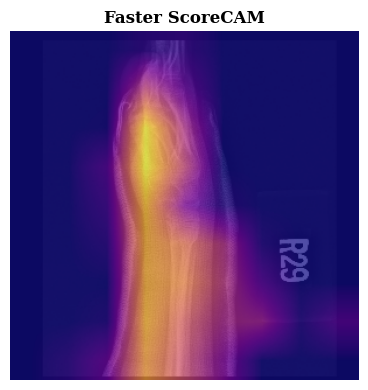

In [124]:
# make a prediction and visualize Faster ScoreCAM
def make_prediction_and_visualize_faster_scorecam():
    img_path = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing/fractured/2.jpg'


    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299)) #IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block32_concat'

    # Generate class activation heatmap
    heatmap = faster_scorecam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_faster_scorecam(img_path, heatmap)

make_prediction_and_visualize_faster_scorecam()


# **Explainable AI (LayerCAM)**

In [125]:
# Function to save and display layercam
def save_and_display_layercam(img_path, heatmap, alpha=0.7):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))  # Resize image to match model input size

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_PLASMA)

    # Apply heatmap on the original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)

    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('LayerCAM', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    # Save the figure
    plt.savefig('/kaggle/working/Dens201_layercam.pdf')  # Save as pdf format
    plt.show()



In [126]:
import tensorflow as tf

def generate_layercam_heatmap(img_array, model, last_conv_layer_name, target_class_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if target_class_index is None:
            target_class_index = tf.argmax(preds[0])
        class_output = preds[:, target_class_index]
        conv_output = last_conv_layer_output[0]

    # Calculate gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(class_output, last_conv_layer_output)[0]

    # Global average pooling (GAP) to compute weights
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Reshape the weights to perform matrix multiplication with the convolutional output
    weights = tf.reshape(weights, (1, 1, -1))

    # Expand dimensions of conv_output for matrix multiplication
    conv_output = tf.expand_dims(conv_output, axis=0)
    conv_output = tf.expand_dims(conv_output, axis=-1)  # Add a new dimension for matrix multiplication

    # Calculate the score-weighted activation map (LayerCAM)
    cam = tf.matmul(weights, conv_output)
    cam = tf.squeeze(cam)
    cam = tf.maximum(cam, 0)  # ReLU to ensure non-negativity
    cam /= tf.reduce_max(cam)  # Normalize

    return cam.numpy()


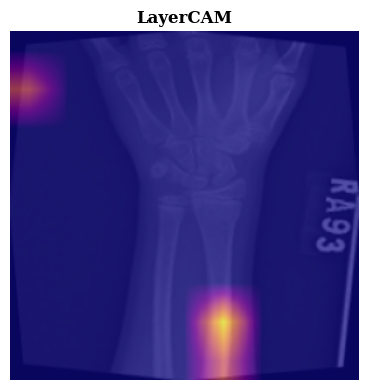

In [127]:
# make a prediction and visualize layercam
def make_prediction_and_visualize_layercam():
    img_path = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing/fractured/1-rotated1-rotated1-rotated2.jpg'

    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))#IMG_WIDTH, IMG_HEIGHT
    rescaled_img = img/255.0
    batch_pred = np.expand_dims(rescaled_img, 0)

    last_conv_layer_name = 'conv5_block32_concat'

    # Generate class activation heatmap
    heatmap = generate_layercam_heatmap(batch_pred, loaded_model, last_conv_layer_name)

    save_and_display_layercam(img_path, heatmap)


make_prediction_and_visualize_layercam()

# **Explainable AI (Vanilla Saliency)**


In [128]:
def save_and_display_saliency_map(img_path, saliency_map):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    saliency_map = cv2.resize(saliency_map, (img.shape[1], img.shape[0]))
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    alpha = 0.4
    blended = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)


    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(blended)
    plt.title('Vanilla Saliency', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('/kaggle/working/Dens201_vanilla_saliency.pdf')
    plt.show()


In [129]:
def generate_vanilla_saliency_map(img_array, model):
    img_tensor = tf.convert_to_tensor(img_array)
    img_tensor = tf.expand_dims(img_tensor, axis=0)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_pred_index = tf.argmax(preds[0])

        # Get the predicted score for the highest probability class
        top_class_score = preds[:, top_pred_index]

    # Compute the gradients of the top class score with respect to the input image
    grads = tape.gradient(top_class_score, img_tensor)
    saliency_map = tf.abs(grads)
    saliency_map = tf.reduce_max(saliency_map, axis=-1)

    return saliency_map[0].numpy()

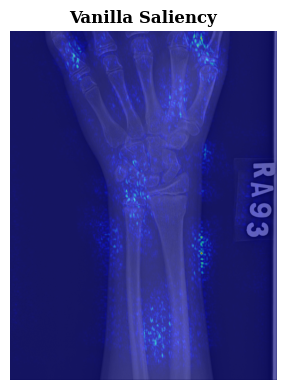

In [133]:

# make a prediction and visualize Vanilla Saliency
def make_prediction_and_visualize_vanilla_saliency():
    img_path = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing/fractured/1.jpg'   

   # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))  # Resize the image to match model input size

    # Preprocess the image (normalize pixel values)
    img = img / 255.0
    


    # Generate class activation heatmap
    saliency_map = generate_vanilla_saliency_map(img, loaded_model)

    
# Display the saliency map overlay
    save_and_display_saliency_map(img_path, saliency_map)

make_prediction_and_visualize_vanilla_saliency()

# **Explainable AI (SmoothGrad)**

In [134]:
def save_and_display_SmoothGrad(img_path, saliency_map):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    saliency_map = cv2.resize(saliency_map, (img.shape[1], img.shape[0]))
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    alpha = 0.4
    blended = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)


    # Display the GradCAM visualization using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(blended)
    plt.title('Smooth Grad', fontdict={'family': 'Serif', 'weight': 'bold', 'size': 12})
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('/kaggle/working/Dens201_smooth_grad.pdf')
    plt.show()



In [135]:
def generate_smoothgrad_saliency_map(img_array, model, n=50, sigma=1.0):
    img_tensor = tf.convert_to_tensor(img_array)
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    img_tensor = tf.cast(img_tensor, dtype=tf.float32)  # Convert to float32

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_pred_index = tf.argmax(preds[0])

        # Get the predicted score for the highest probability class
        top_class_score = preds[:, top_pred_index]

    total_gradients = tf.zeros_like(img_tensor)  # Initialize total gradients

    for _ in range(n):
        # Create perturbed versions of the input image with Gaussian noise
        noise = tf.random.normal(shape=img_tensor.shape, mean=0.0, stddev=sigma)
        perturbed_img = img_tensor + noise

        # Compute gradients for perturbed image
        with tf.GradientTape() as perturbed_tape:
            perturbed_tape.watch(perturbed_img)
            perturbed_preds = model(perturbed_img)
            perturbed_top_class_score = perturbed_preds[:, top_pred_index]

        # Compute gradients of the top class score w.r.t. perturbed image
        perturbed_grads = perturbed_tape.gradient(perturbed_top_class_score, perturbed_img)

        # Accumulate gradients
        total_gradients += perturbed_grads

    # Average gradients over perturbed images
    averaged_gradients = total_gradients / n

    saliency_map = tf.abs(averaged_gradients)
    saliency_map = tf.reduce_max(saliency_map, axis=-1)

    return saliency_map[0].numpy()

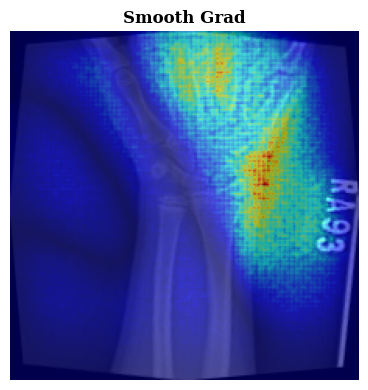

In [136]:
def make_prediction_and_visualize_smoothgrad_saliency():
    img_path = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing/fractured/1-rotated1-rotated1-rotated2.jpg'


    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (299, 299))  # Resize the image to match model input size

    # Preprocess the image (normalize pixel values)
    img = img / 255.0



    # Generate SmoothGrad saliency map
    heatmap = generate_smoothgrad_saliency_map(img, loaded_model)

    # Display the saliency map overlay
    save_and_display_SmoothGrad(img_path, heatmap)


# Assuming loaded_model and other necessary components are defined
make_prediction_and_visualize_smoothgrad_saliency()

